<a href="https://colab.research.google.com/github/sourcecode369/deep-nlp/blob/master/chatbot/Attention_Mechanism_based_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, print_function, unicode_literals, division
from builtins import input, range

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
import urllib

TensorFlow 2.x selected.


In [4]:
# data source: https://github.com/Phylliida/Dialogue-Datasets
import urllib; 
urllib.request.urlretrieve("https://raw.githubusercontent.com/Phylliida/Dialogue-Datasets/master/TwitterLowerAsciiCorpus.txt", filename="TwitterLowerAsciiCorpus.txt")

('TwitterLowerAsciiCorpus.txt', <http.client.HTTPMessage at 0x7fbeac83eba8>)

In [0]:
with open('twitter_tab_format.txt', 'w') as f:
  prev_line = None
  for line in open('TwitterLowerAsciiCorpus.txt'):
    line = line.rstrip()
    if prev_line and line:
      f.write("%s\t%s\n" % (prev_line, line))
    prev_line = line

In [0]:
%tensorflow_version 2.x
import os, sys
import gc
gc.enable()

import numpy as np 
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding, \
Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

In [0]:
def softmax_over_time(x):
  assert(K.ndim(x)>2)
  e = K.exp(x - K.max(x, axis=1, keepdims=True))
  s = K.sum(e, axis=1, keepdims=True)
  return e / s 

In [0]:
# BATCH_SIZE = 64
# BATCH_SIZE = 128
BATCH_SIZE = 256
# BATCH_SIZE = 512

EPOCHS = 100

# LATENT_DIM = 512
# LATENT_DIM = 256
LATENT_DIM = 1024

NUM_SAMPLES = 6000
MAX_SEQUENCE_LEGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 50

In [0]:
input_texts = []
target_texts = []
target_texts_inputs = []

In [10]:
#load in the data
t = 0
for line in open('twitter_tab_format.txt'):
  t+= 1
  if t>NUM_SAMPLES:
    print('Max Samples Exceeded. Breaking out of loop.')
    break
  if '\t' not in line:
    continue
  input_text, translation = line.split('\t')
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation 

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples: ",len(input_texts))

Max Samples Exceeded. Breaking out of loop.
num samples:  6000


In [11]:
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

max_len_input = max(len(s) for s in input_sequences)

tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) 
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1

max_len_target = max(len(s) for s in target_sequences)

Found 8302 unique input tokens.
Found 11819 unique output tokens.


In [12]:
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_data.shape:", encoder_inputs.shape)
print("encoder_data[0]:", encoder_inputs[0])

encoder_data.shape: (6000, 34)
encoder_data[0]: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  237   27 3902   51   64
    4   38   74   16  259  207]


In [13]:
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_data[0]:", decoder_inputs[0])
print("decoder_data.shape:", decoder_inputs.shape)

decoder_data[0]: [   2   19  137  912  526    8   26   80   54 4176   54    3 1645   15
 4177   10   61 2348   25   26 1646    0    0    0    0    0    0    0
    0    0    0    0    0]
decoder_data.shape: (6000, 33)


In [0]:
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

In [15]:
import urllib
print('Downloading pretrained embedding vectors..')
urllib.request.urlretrieve("https://github.com/kmr0877/IMDB-Sentiment-Classification-CBOW-Model/raw/master/glove.6B.50d.txt.gz",filename="glove.6B.50d.txt.gz")

print('Extracting pretrained embedding vectors...')
import gzip
import shutil
with gzip.open('glove.6B.50d.txt.gz', 'rb') as f_in:
    with open('glove.6B.50d.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print('Loading pretrained embedding...')
word2vec = {}
with open('glove.6B.50d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype='float32')
    word2vec[word] = vec
print(f"Found {len(word2vec)} word vectors")

print('Filling pretrained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector      
print('Done.!')

embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_len_input)

Extracting pretrained embedding vectors...
Loading pretrained embedding...
Found 400000 word vectors
Filling pretrained embeddings...
Done.!


In [0]:
decoder_targets_one_hot = np.zeros((len(input_texts), max_len_target, num_words_output), dtype='float32')

In [0]:
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1

In [0]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(LATENT_DIM, return_sequences=True,   dropout=0.5))
encoder_outputs = encoder(x)

decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)
attn_dot = Dot(axes=1)

def one_step_attention(h, st_1):
  st_1 = attn_repeat_layer(st_1)
  x = attn_concat_layer([h, st_1])
  x = attn_dense1(x)
  alphas = attn_dense2(x)
  context = attn_dot([alphas, h])
  return context

decoder_lstm = LSTM(LATENT_DIM, return_state=True,dropout=0.5)
decoder_dense = Dense(num_words_output, activation='softmax')

initial_s = Input(shape=(LATENT_DIM,), name='s0')
initial_c = Input(shape=(LATENT_DIM), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

s = initial_s
c = initial_c

outputs = []
for t in range(max_len_target):
  context = one_step_attention(encoder_outputs, s)
  selector = Lambda(lambda x: x[:,t:t+1])
  xt = selector(decoder_inputs_x)
  decoder_lstm_input = context_last_word_concat_layer([context, xt])
  o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s,c])
  decoder_outputs = decoder_dense(o)
  outputs.append(decoder_outputs)

def stack_and_permute(x):
  x = K.stack(x)
  x = K.permute_dimensions(x, pattern=(1,0,2))
  return x

stacker = Lambda(stack_and_permute)
outputs = stacker(outputs)

model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder, initial_s, initial_c], outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

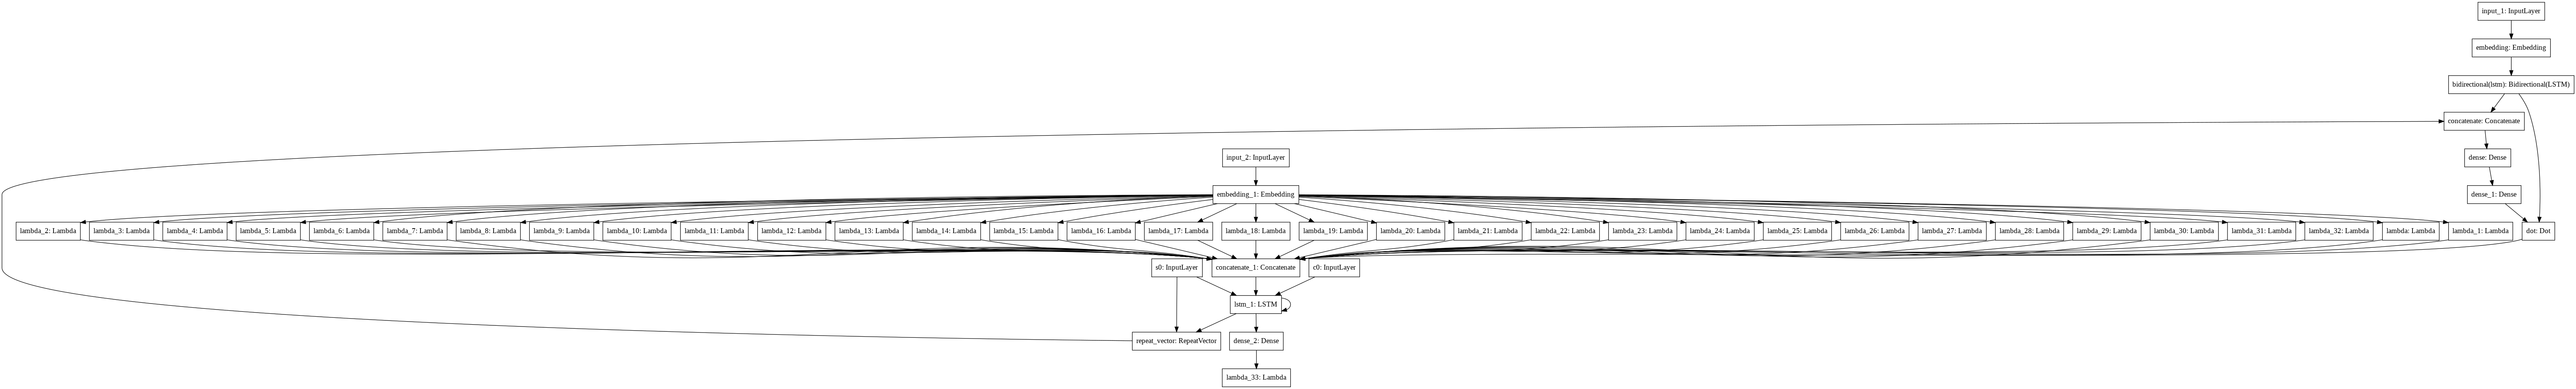

In [19]:
tf.keras.utils.plot_model(model)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 50)       415150      input_1[0][0]                    
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 1024)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 34, 2048)     8806400     embedding[0][0]                  
______________________________________________________________________________________________

In [21]:
z = np.zeros((len(input_texts), LATENT_DIM))
r = model.fit([encoder_inputs, decoder_inputs, z, z], 
              decoder_targets_one_hot, 
              batch_size=BATCH_SIZE, 
              epochs=EPOCHS, 
              validation_split=0.2, 
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,verbose=1,mode='min',restore_best_weights=True),
                         tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,mode='min')],
              verbose=1)

Train on 4800 samples, validate on 1200 samples
Epoch 1/100
4800/4800 [==============================] - 70s 15ms/sample - loss: 3.9420 - accuracy: 0.6321 - val_loss: 3.0966 - val_accuracy: 0.6491
Epoch 2/100
4800/4800 [==============================] - 15s 3ms/sample - loss: 2.7667 - accuracy: 0.6692 - val_loss: 2.9558 - val_accuracy: 0.6491
Epoch 3/100
4800/4800 [==============================] - 15s 3ms/sample - loss: 2.6991 - accuracy: 0.6693 - val_loss: 2.9591 - val_accuracy: 0.6529
Epoch 4/100
4800/4800 [==============================] - 15s 3ms/sample - loss: 2.6650 - accuracy: 0.6722 - val_loss: 2.9961 - val_accuracy: 0.6532
Epoch 5/100
4800/4800 [==============================] - 15s 3ms/sample - loss: 2.6505 - accuracy: 0.6732 - val_loss: 2.9452 - val_accuracy: 0.6542
Epoch 6/100
4800/4800 [==============================] - 15s 3ms/sample - loss: 2.6292 - accuracy: 0.6736 - val_loss: 2.9565 - val_accuracy: 0.6542
Epoch 7/100
4800/4800 [==============================] - 15s 3m

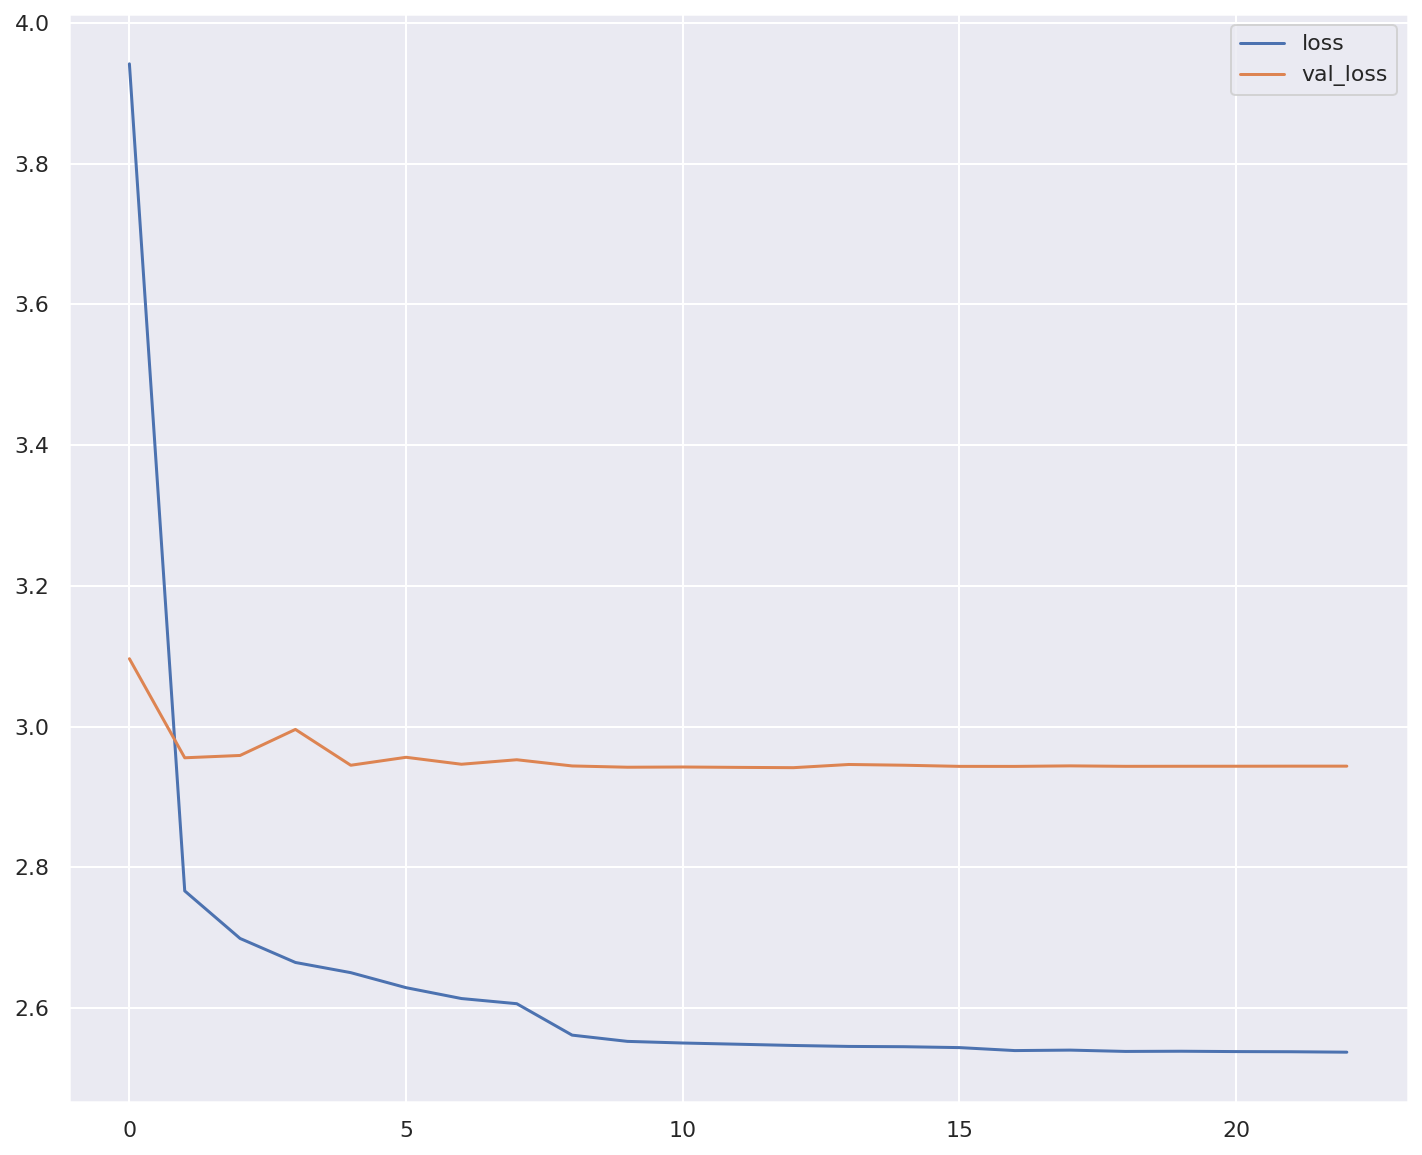

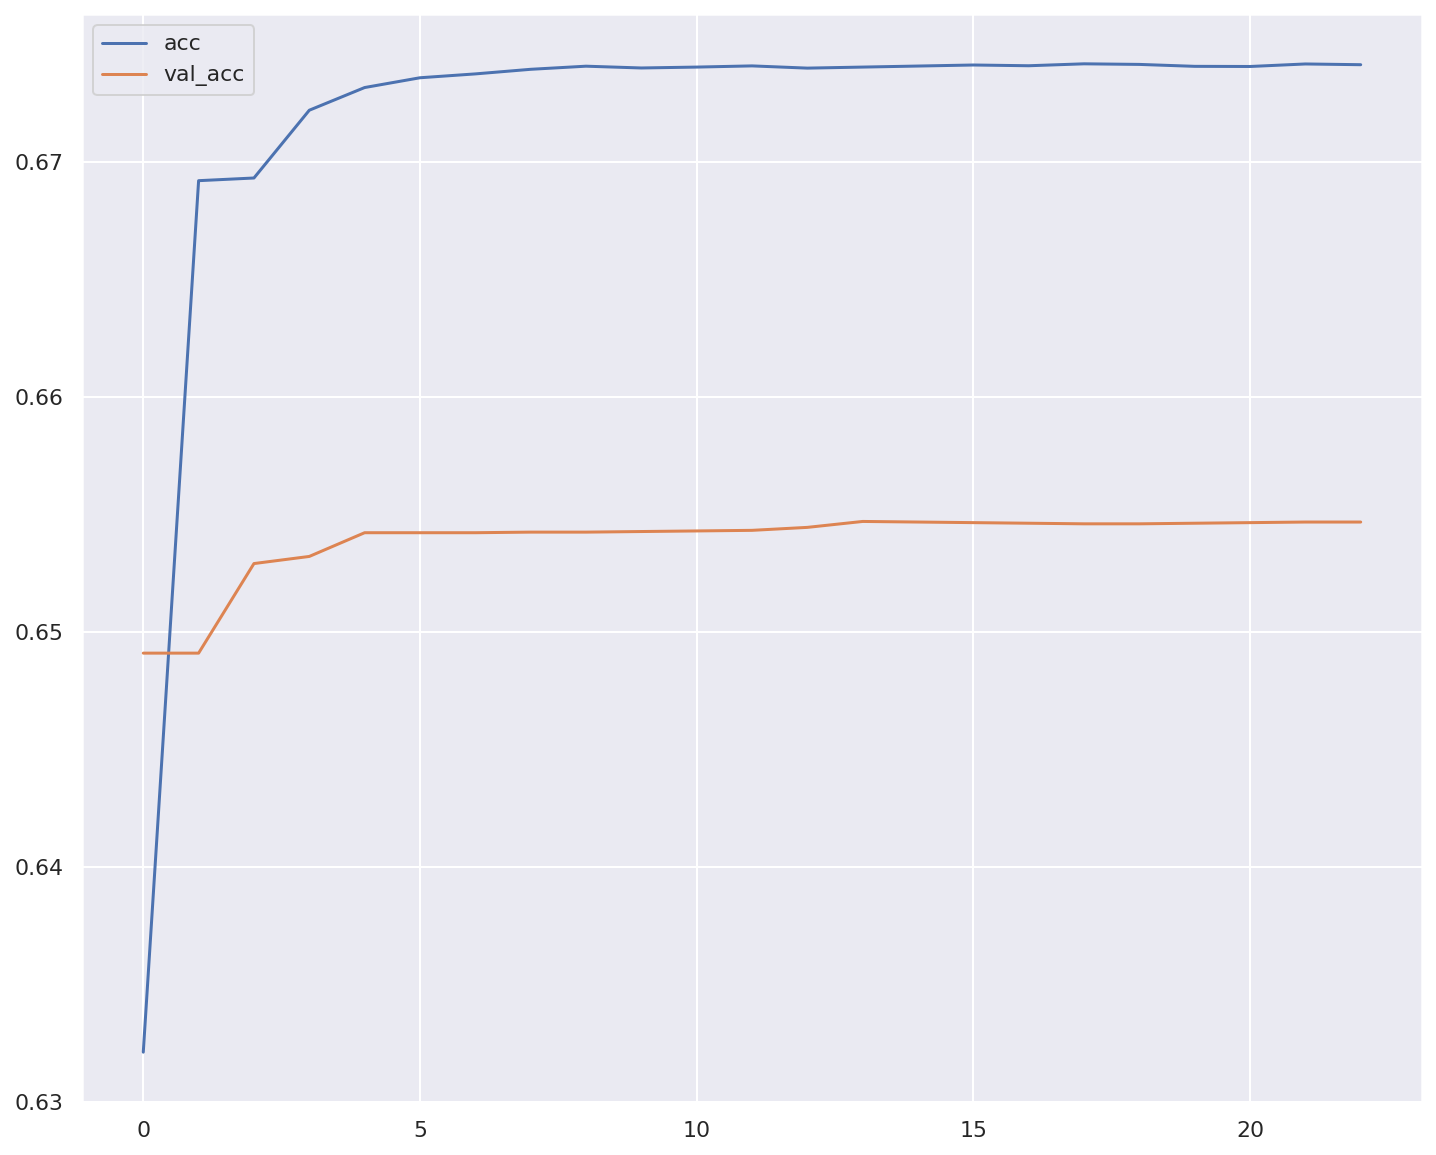

In [26]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_style('whitegrid')
sns.set(rc={"figure.figsize":(12,10)})

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [0]:
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

context = one_step_attention(encoder_outputs_as_input, initial_s)

decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)

decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s, 
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)

idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [0]:
def decode_sequence(input_seq):
  enc_out = encoder_model.predict(input_seq)
  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = word2idx_outputs['<sos>']
  eos = word2idx_outputs['<eos>']
  s = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))
  output_sentence = []
  for _ in range(max_len_target):
    o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
    idx = np.argmax(o.flatten())
    if eos == idx:
      break
    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)
    target_seq[0, 0] = idx
  return ' '.join(output_sentence)

In [31]:
while True:
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input sentence:', input_texts[i])
  print('Predicted translation:', translation)
  print('Actual translation:', target_texts[i])
  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input sentence: wtf you had it for like 8 hours
Predicted translation: i i
Actual translation: i know and i was asleep for 6 of them! she electrocuted herself trying to fix a tv b/c she couldn't afford a repairman
 <eos>
Continue? [Y/n]y
-
Input sentence: honestly, same.
Predicted translation: i i
Actual translation: dude you're like 7 feet tall how much more puberty could you undergo
 <eos>
Continue? [Y/n]y
-
Input sentence: when i go clothes shopping for work.
Predicted translation: i i
Actual translation: idk if you've considered/learned about this yet but there are also clear retainer studs you can wear
 <eos>
Continue? [Y/n]n
